In [1]:
try:
    evaluation = pd.read_csv('testeva.csv',index_col=0)
    evaluation = evaluation.T.sort_index()

    #droplist = ['cnn_train']
    #evaluation = evaluation.drop(droplist)

    fig,ax = plt.subplots(2)
    evaluation[['MSE','rmse']].plot.bar(ax=ax[0])
    ax[0].axhline(np.min(evaluation['MSE']),color='r',ls='--')
    ax[0].axhline(np.min(evaluation['rmse']),color='r',ls='--')

    evaluation[['NSE','R2']].plot.bar(ax=ax[1])
    ax[1].axhline(np.max(evaluation['NSE']),color='r',ls='--')
    ax[1].legend(loc='upper left')
    ax[0].legend(loc='upper left')
except: pass

In [1]:
from DLtools.Trial_evaluation_rec import record_list_result
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import pywt
np.random.seed(42)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #ignore cuDNN log

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/song/anaconda3/envs/tf-gpu-c

In [2]:
from sklearn.metrics import r2_score
def forecast_accuracy(forecast, actual,title=None):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       #MSE

    nse = nashsutcliffe(actual,forecast)
    r2 = r2_score(actual, forecast)
    result = {'MSE':mse,'rmse':rmse,'R2':r2,'NSE':nse,'mape':mape,  'mae': mae,
            'mpe': mpe}
    result =  pd.Series(result,name=title)
    if title!=None:
        try: 
          eval = pd.read_csv('testeva.csv',index_col=0)
          pd.concat([eval,result],axis=1).to_csv('testeva.csv')
        except:
          eval = pd.DataFrame(result)
          eval.to_csv('testeva.csv')
    return result

def nashsutcliffe(Y_evaluation, Yhat_simulation):
    """
    Nash-Sutcliffe model efficinecy
        .. math::
         NSE = 1-\\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})^2}{\\sum_{i=1}^{N}(e_{i}-\\bar{e})^2} 
    :evaluation: Observed data to compared with simulation data.
    :type: list
    :simulation: simulation data to compared with evaluation data
    :type: list
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    """
    if len(Y_evaluation) == len(Yhat_simulation):
        s, e = np.array(Yhat_simulation), np.array(Y_evaluation)
        # s,e=simulation(Yhat),evaluation(Y)
        mean_observed = np.nanmean(e)
        # compute numerator and denominator
        numerator = np.nansum((e - s) ** 2)
        denominator = np.nansum((e - mean_observed)**2)
        # compute coefficient
        return 1 - (numerator / denominator)

In [3]:
############# Keras ###################
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [19]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*6,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [20]:
#--------------------------- 2 Yr Edit -----------------------------------#
#host_path = './CPY012/2Yr_flood/'
#start_p = '2016-01-01'
#split_date = '2017-05-10'
#stop_p = '2018-01-01'
split_date = '2016-11-01'

In [21]:
#-----------------------Baseline / Hybrid -----------------------------------#
save_path =host_path+'trial'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [22]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

In [23]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

#------------------------
syn = ''
Yscale = False
allscale=True

data_mar.columns

Index(['CPY012_wl', 'BKK021_wl', 'PIN004_wl', 'CPY006_wl', 'BKK013_wl',
       'YOM012_wl', 'NAN009_wl', 'DNP028_press', 'WAN003_wl', 'WAN005_wl'],
      dtype='object')

# Split triantest

In [8]:
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=3)
    coeff = np.array(coeff)

    cA3,cD3 = coeff[0][0],coeff[0][1]
    _,cD2 = coeff[1][0],coeff[1][1]
    _,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            '{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
def syn_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    _col =list()
    for i in data_col:
        if i[2]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]

def st_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    _col =list()
    for i in data_col:
        if i[0]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]

In [24]:
wdata = df_wavelet(data_mar,False)
wdata_A3 = syn_column_select(wdata,'cA3')
wdata_D3 = syn_column_select(wdata,'cD3')
wdata_D2 = syn_column_select(wdata,'cD2')
wdata_D1 = syn_column_select(wdata,'cD1')

In [25]:
cpy = st_column_select(wdata,'CPY012')

##----------- SCALE
if allscale:
    syn = syn+'[X_sc]'  
    def scale_x(data):
        scaler = MinMaxScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
        return data
    wdata_A3 = scale_x(wdata_A3)
    wdata_D3 = scale_x(wdata_D3)
    wdata_D2 = scale_x(wdata_D2)
    wdata_D1 = scale_x(wdata_D1)

# Y data
#if Yscale:
#    syn = syn+'[y_sc]'        
#    scaler_tar = MinMaxScaler()
#    scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
    
#scaler_tar = MinMaxScaler()
#scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
#data_mar[target] = scaler_tar.transform(data_mar[target].to_numpy().reshape(-1,1))

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

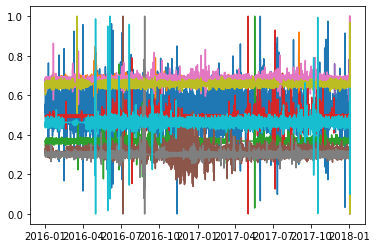

In [123]:
plt.plot(wdata_D1)

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

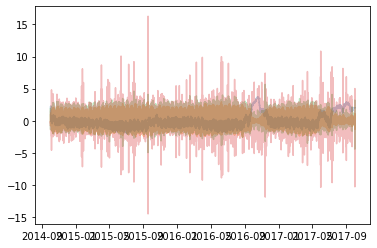

In [26]:
std_sc = StandardScaler()
cpy[cpy.columns] = std_sc.fit_transform(cpy[cpy.columns])
plt.plot(cpy,alpha=0.3)

<AxesSubplot:xlabel='date'>

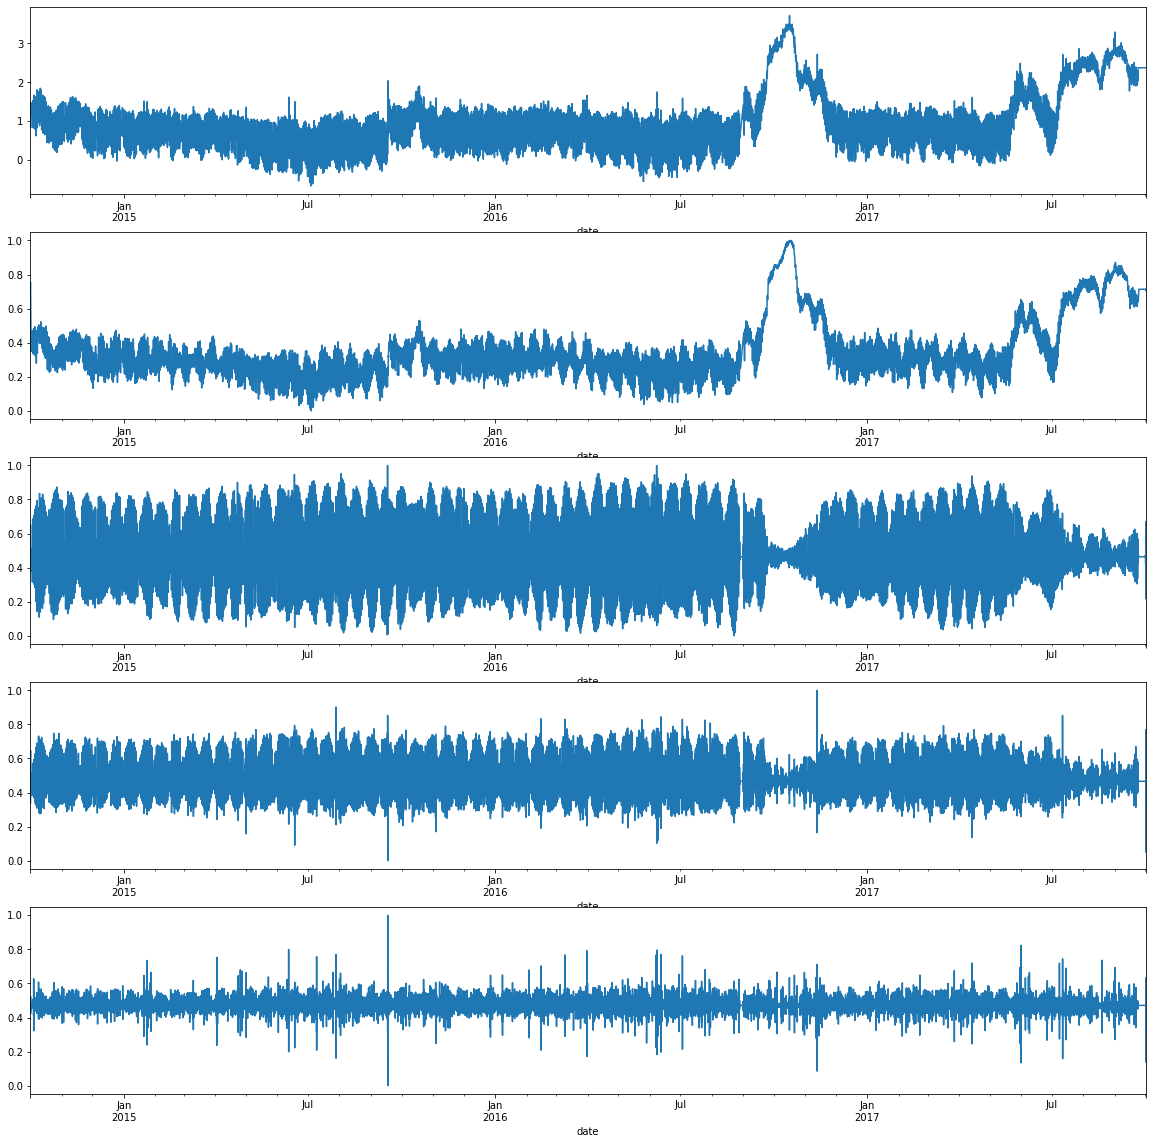

In [27]:
fig,ax = plt.subplots(5,1, figsize=(20,20))
data_mar.iloc[:,0].plot(ax=ax[0])
wdata_A3.iloc[:,0].plot(ax=ax[1])
wdata_D3.iloc[:,0].plot(ax=ax[2])
wdata_D2.iloc[:,0].plot(ax=ax[3])
wdata_D1.iloc[:,0].plot(ax=ax[4])

In [28]:
def autosplit(data):    
    ##----------- train test split 
    train,test = data[:split_date],data[split_date:]
    # ##--------- Wavelet_traintest
    X_train, y_train = split_xy(train,n_past,n_future)
    X_test, y_test= split_xy(test,n_past,n_future)
    return [X_train,X_test],[y_train,y_test]

In [29]:
train,test = wdata[:split_date],wdata[split_date:]
n_features = n_features*4
X_train, y_train = split_xy(train,n_past,n_future)
X_test, y_test= split_xy(test,n_past,n_future)

In [32]:
y_train.shape

(18097, 72)

In [142]:
Xa3,Ya3=autosplit(wdata_A3)
Xd3,Yd3=autosplit(wdata_D3)
Xd2,Yd2=autosplit(wdata_D2)
Xd1,Yd1=autosplit(wdata_D1)

In [144]:
train,test = cpy[:split_date],cpy[split_date:]

x,y = split_series(train.values,n_past,n_future)
x = x.reshape((x.shape[0], x.shape[1],4))
yA3_train = y[:,:,0]
yD3_train = y[:,:,1]
yD2_train = y[:,:,2]
yD1_train = y[:,:,3]
#--------------------------------------------
x,y = split_series(test.values,n_past,n_future)
x = x.reshape((x.shape[0], x.shape[1],4))
yA3_test = y[:,:,0]
yD3_test = y[:,:,1]
yD2_test = y[:,:,2]
yD1_test = y[:,:,3]
#--------------------------------------------
Ya3_std = [yA3_train,yA3_test]
Yd3_std = [yD3_train,yD3_test]
Yd2_std = [yD2_train,yD2_test]
Yd1_std = [yD1_train,yD1_test]

In [200]:
masterX,masterY =autosplit(data_mar)

# Deep learning

In [10]:
#------------ DL PARAMETER ---------------------#
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=2, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]

In [11]:
def runmodel(model,X,Y):
    history = model.fit(X[0],Y[0],epochs=epochs,validation_data=(X[1],Y[1]),batch_size=batch,verbose=verbose,callbacks=callbacks)
    trainPred = model.predict(X[0])
    testPred = model.predict(X[1])

    if Yscale:
        Y[0] = scaler_tar.inverse_transform(Y[0])
        trainPred = scaler_tar.inverse_transform(trainPred.reshape(Y[0].shape))
        Y[1] = scaler_tar.inverse_transform(Y[1])
        testPred = scaler_tar.inverse_transform(testPred.reshape(Y[1].shape))
    return trainPred,testPred

In [34]:
#----------------------------------------------------------#
def build_lstm():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss=loss_f, optimizer=my_optimizer)
    model.summary()
    return model
#-------------------------------------------------------------#
def build_lstm_batch():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss=loss_f, optimizer=my_optimizer)
    model.summary()
    return model
#------------------------------------------------------------#
def build_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer=my_optimizer, loss=loss_f)    
    model.summary()
    return model
#-------------------------------------------------------------#
def build_ann():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Flatten()(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer=my_optimizer, loss=loss_f)    
    model.summary()
    return model
#-------------------------------------------------------------#

In [13]:
def showresult(Yhat,Y):
    print(forecast_accuracy(Yhat[0],Y[0]))
    print(forecast_accuracy(Yhat[1],Y[1]))

    for i in range(1,72,24):
        plt.title(syn)
        plt.plot(Y[1][:,i],alpha=0.1)
        plt.plot(Yhat[1][:,i],color='red')
    plt.legend()

In [42]:
import tensorflow.keras.backend as K

def ctc_loss(y_true, y_pred):

    return K.ctc_batch_cost(y_true, y_pred, n_past, n_future)
    #where input_length and label_length are constants you created previously
    #the easiest way here is to have a fixed batch size in training 
    #the lengths should have the same batch size (see shapes in the link for ctc_cost)    

In [44]:
def ctc_custom(prediction_batch, label_batch):
    pred_batch_size = prediction_batch.get_shape().as_list() # returns (?,?,?) at compile time
    label_batch_size = label_batch.get_shape().as_list()
    samples = pred_batch_size[0]

    input_length = tf.placeholder([[20] for x in range(samples)])
    label_length = tf.placeholder([[len(l)] for l in label_batch_size])
    return ctc_batch_cost(label_batch, prediction_batch, input_length, label_length)

#  [transform]> [wav] > [DL] > [wav] > [Inversetransform] 

In [14]:
# inverse transform
def inverse_WT(cA3,cD3,cD2,cD1):
#predTrain = inverse_WT(cA3ytrain,d1_PreTrain,d1_PreTrain,d1_PreTrain)
#predTest = inverse_WT(cA3ytest,cD3ytest,cD2ytest,cD1ytest)
    wav=list()
    for i in range(cA3.shape[0]):
        iwave = pywt.iswt((cA3[i,:],cD3[i,:],cD2[i,:],cD1[i,:]),'db4')
        wav.append(iwave)
    return np.array(wav)


ANN

In [94]:
ann = build_ann()
verbose, epochs,batch = 1, 30,8
#my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
my_optimizer = 'adam'
loss_f = 'mse'



Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 1680)              0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 1680)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 200)               336200    
_________________________________________________________________
dropout_49 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 144)               28944     
_________________________________________________________________
dense_66 (Dense)             (None, 72)                104

Epoch 00007: early stopping


MSE     0.733723
rmse    0.856576
R2      0.794605
NSE     0.794607
mape    0.920825
mae     0.701856
mpe     0.032191
dtype: float64
MSE     1.132336
rmse    1.064113
R2      0.798238
NSE     0.798264
mape    0.185720
mae     0.921477
mpe    -0.018532
dtype: float64


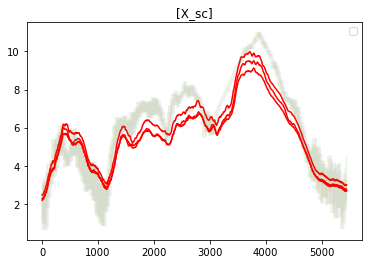

In [28]:
a3_predict = runmodel(ann,Xa3,[yA3_train,yA3_test])
showresult(a3_predict,[yA3_train,yA3_test])

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE         0.171282
rmse        0.413862
R2          0.357447
NSE         0.357421
mape    29702.761719
mae         0.330876
mpe    -20593.998047
dtype: float64
MSE     0.043326
rmse    0.208149
R2      0.328981
NSE     0.329032
mape         inf
mae     0.142443
mpe          NaN
dtype: float64


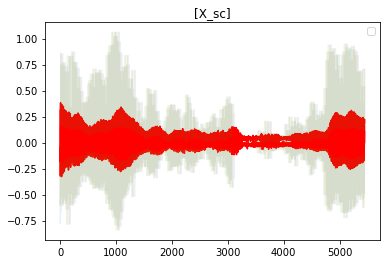

In [29]:
d3_predict = runmodel(ann,Xd3,[yD3_train,yD3_test])
showresult(d3_predict,[yD3_train,yD3_test])

Epoch 00024: early stopping


/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-c

MSE     0.015374
rmse    0.123994
R2      0.002601
NSE     0.002600
mape         inf
mae     0.094667
mpe          NaN
dtype: float64
MSE     0.004884
rmse    0.069882
R2     -0.004753
NSE    -0.004753
mape         inf
mae     0.045793
mpe          NaN
dtype: float64


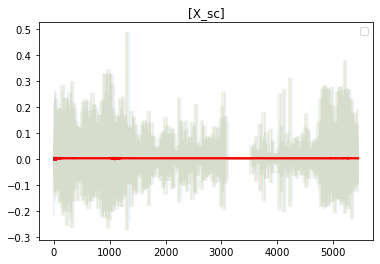

In [30]:
d2_predict = runmodel(ann,Xd2,[yD2_train,yD2_test])
showresult(d2_predict,[yD2_train,yD2_test])

In [ ]:
iwaveTest = inverse_WT(a3_predict[1],d3_predict[1],d2_predict[1],d1_predict[1])

In [ ]:
ytest = Y[1]
sc =  MinMaxScaler()
sc.fit(ytest)

# CNN invertranform

In [53]:
verbose, epochs,batch = 1, 30,8
#my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
my_optimizer = 'adam'
loss_f = 'mse'

model_c = build_cnn1d()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 167, 64)           1344      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 5312)              0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 5312)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 200)               1062600   
_________________________________________________________________
dropout_31 (Dropout)         (None, 200)               0  

Train on 11665 samples, validate on 5449 samples
Epoch 1/100
11665/11665 [==============================] - 6s 484us/sample - loss: 1.3767 - val_loss: 0.8345
Epoch 2/100
11665/11665 [==============================] - 5s 456us/sample - loss: 0.5298 - val_loss: 1.0099
Epoch 3/100
11665/11665 [==============================] - 6s 474us/sample - loss: 0.4882 - val_loss: 0.9662
Epoch 00003: early stopping


MSE     0.328100
rmse    0.572800
R2      0.908150
NSE     0.908154
mape    0.649762
mae     0.463306
mpe     0.039949
dtype: float64
MSE     0.966178
rmse    0.982943
R2      0.827759
NSE     0.827867
mape    0.148961
mae     0.816191
mpe    -0.068663
dtype: float64


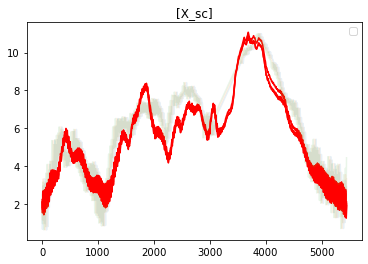

In [58]:
a3_PreTrain_c,a3_PreTest_c = runmodel(model_c,Xa3,[yA3_train,yA3_test])
showresult([a3_PreTrain_c,a3_PreTest_c],[yA3_train,yA3_test])

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.2561 - val_loss: 0.0483
Epoch 2/30
11665/11665 [==============================] - 12s 996us/sample - loss: 0.1709 - val_loss: 0.0316
Epoch 3/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.1226 - val_loss: 0.0280
Epoch 4/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.0988 - val_loss: 0.0262
Epoch 5/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.0842 - val_loss: 0.0255
Epoch 6/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.0754 - val_loss: 0.0256
Epoch 7/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.0705 - val_loss: 0.0254
Epoch 8/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.0666 - val_loss: 0.0253
Epoch 9/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.0640 - val

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE         0.035954
rmse        0.189616
R2          0.865154
NSE         0.865114
mape    35888.394531
mae         0.149300
mpe     14601.083008
dtype: float64
MSE     0.020693
rmse    0.143850
R2      0.679339
NSE     0.679539
mape         inf
mae     0.108908
mpe          NaN
dtype: float64


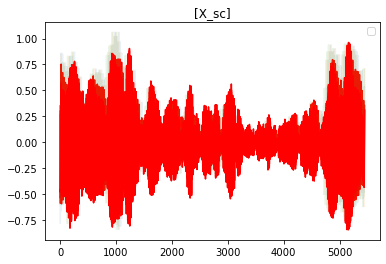

In [54]:
d3_PreTrain_c,d3_PreTest_c = runmodel(model_c,Xd3,[yD3_train,yD3_test])
showresult([d3_PreTrain_c,d3_PreTest_c],[yD3_train,yD3_test])

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.2307 - val_loss: 0.0050
Epoch 2/30
11665/11665 [==============================] - 13s 1ms/sample - loss: 0.0136 - val_loss: 0.0043
Epoch 3/30
11665/11665 [==============================] - 12s 1ms/sample - loss: 0.0121 - val_loss: 0.0040
Epoch 4/30
11665/11665 [==============================] - 13s 1ms/sample - loss: 0.0113 - val_loss: 0.0038
Epoch 5/30
11665/11665 [==============================] - 13s 1ms/sample - loss: 0.0107 - val_loss: 0.0037
Epoch 6/30
11665/11665 [==============================] - 13s 1ms/sample - loss: 0.0104 - val_loss: 0.0037
Epoch 7/30
11665/11665 [==============================] - 13s 1ms/sample - loss: 0.0101 - val_loss: 0.0036
Epoch 8/30
11665/11665 [==============================] - 13s 1ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 9/30
11665/11665 [==============================] - 13s 1ms/sample - loss: 0.0096 - val_l

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-c

MSE     0.006811
rmse    0.082531
R2      0.558144
NSE     0.558123
mape         inf
mae     0.062910
mpe          NaN
dtype: float64
MSE     0.003298
rmse    0.057428
R2      0.321390
NSE     0.321451
mape         inf
mae     0.039472
mpe          NaN
dtype: float64


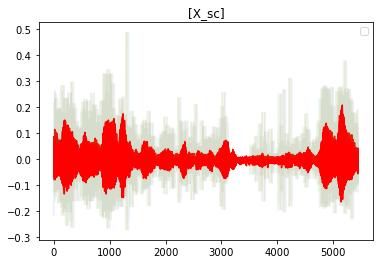

In [56]:
d2_PreTrain_c_,d2_PreTest_c_ = runmodel(model_c,Xd2,[yD2_train,yD2_test])
showresult([d2_PreTrain_c_,d2_PreTest_c_],[yD2_train,yD2_test])

Train on 11665 samples, validate on 5449 samples
Epoch 1/100
11665/11665 [==============================] - 2s 137us/sample - loss: 0.0231 - val_loss: 0.0021
Epoch 2/100
11665/11665 [==============================] - 2s 160us/sample - loss: 0.0099 - val_loss: 0.0020
Epoch 3/100
11665/11665 [==============================] - 3s 220us/sample - loss: 0.0090 - val_loss: 0.0025
Epoch 4/100
11665/11665 [==============================] - 2s 133us/sample - loss: 0.0084 - val_loss: 0.0020
Epoch 5/100
11665/11665 [==============================] - 2s 147us/sample - loss: 0.0079 - val_loss: 0.0024
Epoch 6/100
11665/11665 [==============================] - 2s 131us/sample - loss: 0.0074 - val_loss: 0.0024
Epoch 00006: early stopping


/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.002355
rmse    0.048526
R2     -0.059502
NSE    -0.059491
mape         inf
mae     0.031801
mpe          inf
dtype: float64
MSE     0.002437
rmse    0.049369
R2     -0.468174
NSE    -0.468175
mape         inf
mae     0.034802
mpe          inf
dtype: float64


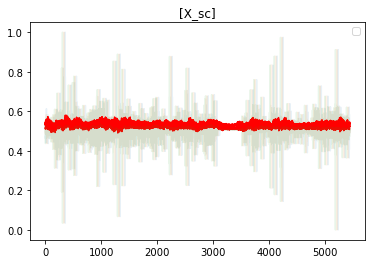

In [68]:
verbose, epochs,batch = 1, 100,16
d1_PreTrain_c,d1_PreTest_c = runmodel(model_c,Xd1,[yD1_train_sc,yD1_test_sc])
showresult([d1_PreTrain_c,d1_PreTest_c],[yD1_train_sc,yD1_test_sc])

In [ ]:
iwaveTest = inverse_WT(a3_PreTest_c,d3_PreTest_c,d2_PreTest_c_,d1_PreTest_c)

ytest = Y[1]
scaler_tar = MinMaxScaler()
scaler_tar.fit(ytest)

iwaveTest = scaler_tar.transform(iwaveTest)
#ytest = ytest.reshape(Y[1].shape)
for i in range(5):
    #plt.plot(ytest[:,i])
    plt.plot(iwaveTest[:,i],alpha=0.1)
    

# cD1 problem analyst

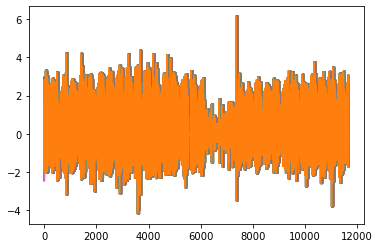

In [145]:
plt.plot(Yd2_std[0],)

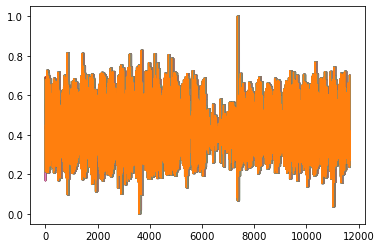

In [106]:
plt.plot(Yd2[0])

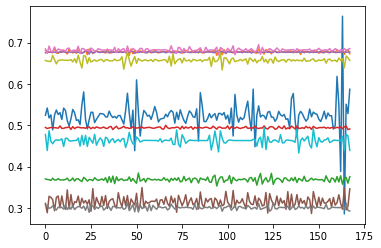

In [147]:
plt.plot(Xd1[0][10,:,:])

In [166]:
def build_mod_ann():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Flatten()(input)
    #x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(n_future,activation = 'linear')(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer=my_optimizer, loss=loss_f)    
    model.summary()
    return model

In [167]:
verbose, epochs,batch = 1, 30,16
my_optimizer = 'adam'
loss_f = 'mse'
callbacks = [callback_early_stopping,reduce_lr]

ann2 = build_mod_ann()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 1680)              0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 1680)              0         
_________________________________________________________________
dense_112 (Dense)            (None, 200)               336200    
_________________________________________________________________
dropout_81 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_114 (Dense)            (None, 72)                727

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 7s 572us/sample - loss: 1.3730 - val_loss: 0.4027
Epoch 2/30
11665/11665 [==============================] - 6s 517us/sample - loss: 1.2938 - val_loss: 0.4019
Epoch 3/30
11665/11665 [==============================] - 6s 525us/sample - loss: 1.2829 - val_loss: 0.4016
Epoch 4/30
11665/11665 [==============================] - 6s 504us/sample - loss: 1.2778 - val_loss: 0.4016
Epoch 5/30
11665/11665 [==============================] - 6s 479us/sample - loss: 1.2759 - val_loss: 0.4016
Epoch 6/30
11665/11665 [==============================] - 6s 514us/sample - loss: 1.2750 - val_loss: 0.4016
Epoch 00006: early stopping


MSE       1.273473
rmse      1.128483
R2       -0.000019
NSE      -0.000018
mape    104.463051
mae       0.860186
mpe       1.869377
dtype: float64
MSE       0.401559
rmse      0.633687
R2       -0.000059
NSE      -0.000059
mape    867.305725
mae       0.410568
mpe       2.482057
dtype: float64


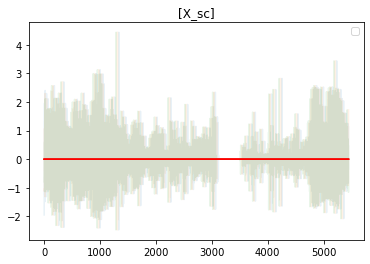

In [168]:
d2_predict = runmodel(ann2,Xd2,Yd2_std)
showresult(d2_predict,Yd2_std)

# another trial

In [189]:
def build_mod_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(x)
    x = layers.BatchNormalization()(x) # added
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(x)
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(2000, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1000, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(n_future, activation='linear')(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model

In [227]:
verbose, epochs,batch = 1, 30,16
my_optimizer = 'adam'
loss_f = 'mse'
callbacks = [reduce_lr]

model=build_mod_cnn1d()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 167, 64)           1344      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 166, 64)           8256      
_________________________________________________________________
batch_normalization_13 (Batc (None, 166, 64)           256       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 83, 64)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 82, 64)            8256      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 81, 64)            825

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 5s 441us/sample - loss: 0.0077 - val_loss: 0.0035
Epoch 2/30
11665/11665 [==============================] - 5s 389us/sample - loss: 0.0064 - val_loss: 0.0033
Epoch 3/30
11665/11665 [==============================] - 4s 354us/sample - loss: 0.0061 - val_loss: 0.0030
Epoch 4/30
11665/11665 [==============================] - 4s 384us/sample - loss: 0.0059 - val_loss: 0.0030
Epoch 5/30
11665/11665 [==============================] - 5s 445us/sample - loss: 0.0057 - val_loss: 0.0032
Epoch 00005: early stopping


/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.005808
rmse    0.076207
R2      0.514460
NSE     0.514437
mape         inf
mae     0.059025
mpe          inf
dtype: float64
MSE     0.003200
rmse    0.056571
R2      0.151230
NSE     0.151426
mape    0.104273
mae     0.042561
mpe    -0.050206
dtype: float64


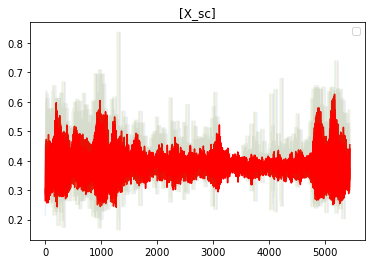

In [193]:
d2_predict_dc = runmodel(model,Xd2,Yd2)
showresult(d2_predict_dc,Yd2)

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 6s 524us/sample - loss: 0.0607 - val_loss: 0.0258
Epoch 2/30
11665/11665 [==============================] - 5s 435us/sample - loss: 0.0096 - val_loss: 0.0038
Epoch 3/30
11665/11665 [==============================] - 5s 405us/sample - loss: 0.0055 - val_loss: 0.0025
Epoch 4/30
11665/11665 [==============================] - 5s 452us/sample - loss: 0.0046 - val_loss: 0.0019
Epoch 5/30
11665/11665 [==============================] - 5s 402us/sample - loss: 0.0041 - val_loss: 0.0043
Epoch 6/30
11665/11665 [==============================] - 5s 408us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 7/30
11665/11665 [==============================] - 5s 394us/sample - loss: 0.0036 - val_loss: 0.0018
Epoch 8/30
11665/11665 [==============================] - 5s 437us/sample - loss: 0.0035 - val_loss: 0.0022
Epoch 9/30
11665/11665 [==============================] - 5s 403us/sample - loss: 0.003

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.002364
rmse    0.048621
R2     -0.148773
NSE    -0.148780
mape         inf
mae     0.032558
mpe          inf
dtype: float64
MSE     0.001880
rmse    0.043361
R2     -0.212292
NSE    -0.212297
mape    0.055752
mae     0.026782
mpe    -0.017587
dtype: float64


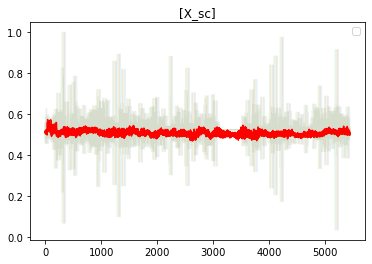

In [228]:
d1_predict_dc = runmodel(model,Xd1,Yd1)
showresult(d1_predict_dc,Yd1)

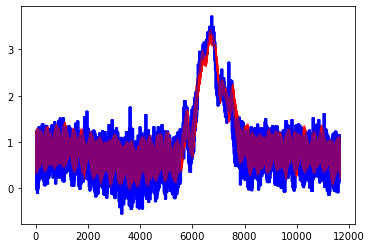

In [229]:
#[a3_PreTrain_c,a3_PreTest_c],[d3_PreTrain_c,d3_PreTest_c],d2_predict_dc,d1_predict_dc
iwave = inverse_WT(a3_PreTrain_c,d3_PreTrain_c,d2_predict_dc[0],d1_predict_dc[0])

ytrain = masterY[0]
#scaler_tar = MinMaxScaler()
#scaler_tar.fit(ytrain)
#scaler_tar.inverse_transform(iwave)
#ytest = ytest.reshape(Y[1].shape)
for i in range(72):
    plt.plot(ytrain[:,i],color='blue',alpha=0.1)
    plt.plot(iwave[:,i],alpha=0.1,color='red')

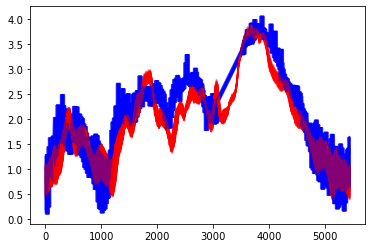

In [230]:
#[a3_PreTrain_c,a3_PreTest_c],[d3_PreTrain_c,d3_PreTest_c],d2_predict_dc,d1_predict_dc
iwave = inverse_WT(a3_PreTest_c,d3_PreTest_c,d2_predict_dc[1],d1_predict_dc[1])

ytest = masterY[1]
#scaler_tar = MinMaxScaler()
#scaler_tar.fit(ytest)
#iwave = scaler_tar.inverse_transform(iwave)
#ytest = ytest.reshape(Y[1].shape)
for i in range(72):
    plt.plot(ytest[:,i],color='blue',alpha=0.1)
    plt.plot(iwave[:,i],alpha=0.1,color='red')

LSTM batch

In [78]:
def build_mod_lstm_batch():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=True)(input)
    x = layers.CuDNNLSTM(100,input_shape=(n_past, n_features),return_sequences=False)(x)
    x = layers.BatchNormalization()(x)#add
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='tanh')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(n_future,activation='tanh')(x)
    
    #out = layers.Reshape((1,n_future))(x)
    model = keras.Model(inputs=[input], outputs=out)

    model.compile(loss='mse', optimizer=my_optimizer,metrics='accuracy')
    model.summary()
    return model

In [83]:
verbose, epochs,batch = 1, 30,8
#my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
my_optimizer = 'adam'
loss_f = 'mean_squared_logarithmic_error' #notwork
callbacks = [reduce_lr]
# callbacks = [callback_early_stopping,reduce_lr]
mod_lstm = build_mod_lstm_batch()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 168, 200)          169600    
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, 100)               120800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_47 (Dropout)         (None, 100)               0  

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 46s 4ms/sample - loss: 0.2066 - val_loss: 0.0604
Epoch 2/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0339 - val_loss: 0.0053
Epoch 3/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0072 - val_loss: 0.0045
Epoch 4/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0059 - val_loss: 0.0032
Epoch 5/30
11665/11665 [==============================] - 45s 4ms/sample - loss: 0.0055 - val_loss: 0.0070
Epoch 6/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0053 - val_loss: 0.0063
Epoch 7/30
11665/11665 [==============================] - 45s 4ms/sample - loss: 0.0051 - val_loss: 0.0080
Epoch 8/30
11665/11665 [==============================] - 44s 4ms/sample - loss: 0.0050 - val_loss: 0.0176
Epoch 9/30
11665/11665 [==============================] - 45s 4ms/sample - loss: 0.0048 - val_l

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.002140
rmse    0.046263
R2     -0.040059
NSE    -0.040045
mape         inf
mae     0.029376
mpe          inf
dtype: float64
MSE     0.001645
rmse    0.040555
R2     -0.060495
NSE    -0.060489
mape    0.046244
mae     0.021711
mpe    -0.008084
dtype: float64


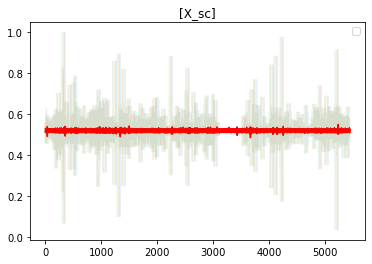

In [84]:
d1_PreTrain_c,d1_PreTest_c = runmodel(mod_lstm,Xd1,Yd1)
showresult([d1_PreTrain_c,d1_PreTest_c],Yd1)

In [63]:
def build_mod():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(100,input_shape=(n_past, n_features),return_sequences=True)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100)(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(n_future,activation='sigmoid')(x)
    
    #out = layers.Reshape((1,n_future))(x)
    model = keras.Model(inputs=[input], outputs=out)

    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model

In [64]:
verbose, epochs,batch = 1, 30,8
#my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
my_optimizer = 'adam'
loss_f = 'mse'

mod = build_mod()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 168, 10)]         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 168, 100)          44800     
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 200)               241600    
_________________________________________________________________
dropout_34 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 72)                727

In [65]:
d1_Predict_mod = runmodel(mod,Xd1,[yD1_train,yD1_test])
showresult(d1_Predict_mod,[yD1_train,yD1_test])

Train on 11665 samples, validate on 5449 samples
Epoch 1/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0615 - val_loss: 0.0018
Epoch 2/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0047 - val_loss: 0.0014
Epoch 3/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0027 - val_loss: 0.0014
Epoch 4/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0022 - val_loss: 0.0014
Epoch 5/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 6/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 7/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 8/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_loss: 0.0014
Epoch 9/30
11665/11665 [==============================] - 23s 2ms/sample - loss: 0.0019 - val_l

KeyboardInterrupt: 

GRU no work

ann no work


# Just throw all to dl

In [32]:
def build_lstm4():
    global n_past,n_future,n_features
    inputA3 = keras.Input(shape=(n_past, n_features), name="cA3")
    inputD3 = keras.Input(shape=(n_past, n_features), name="cD3")
    inputD2 = keras.Input(shape=(n_past, n_features), name="cD2")
    inputD1 = keras.Input(shape=(n_past, n_features), name="cD1")
    #x is the CNN for approximate
    a = layers.CuDNNLSTM(200,return_sequences=False)(inputA3)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100,activation = 'relu')(a)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100, activation='relu')(a)

    #y is the LSTM for detail  
    b = layers.CuDNNLSTM(200,return_sequences=False)(inputD3)
    b = layers.Dropout(0.2)(b)
    b = layers.Dense(100,activation = 'relu')(b)
    b = layers.Dropout(0.2)(b)
    b = layers.Dense(10,activation='sigmoid')(b)
    
    c = layers.CuDNNLSTM(200,return_sequences=False)(inputD2)
    c = layers.Dropout(0.2)(c)
    c= layers.Dense(100,activation = 'relu')(c)
    c = layers.Dropout(0.2)(c)
    c = layers.Dense(10,activation='sigmoid')(c)
    
    d = layers.CuDNNLSTM(200,return_sequences=False)(inputD1)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(100,activation = 'relu')(d)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(10,activation='sigmoid')(d)
    #combining 2 lstm
    com = layers.concatenate([a,b,c,d])
    # z = LSTM(200, activation='relu', return_sequences=False)(com)
    # z = Dense(100, activation="relu")
    z = layers.Dense(n_future)(com)
    model = keras.Model(inputs=[inputA3, inputD3,inputD2,inputD1], outputs=z)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model

In [33]:
X,Y = autosplit(data_mar)

In [34]:
Xtrain = (Xa3[0],Xd3[0],Xd2[0],Xd1[0])
Xtest = (Xa3[1],Xd3[1],Xd2[1],Xd1[1])
model=build_lstm4()
history = model.fit(Xtrain,Y[0],epochs=epochs,validation_data=(Xtest,Y[1]),batch_size=batch,verbose=verbose,callbacks=callbacks)
trainPred = model.predict(Xtrain)
testPred = model.predict(Xtest)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cA3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD2 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD1 (InputLayer)                [(None, 168, 10)]    0                                            
____________________________________________________________________________________________

NameError: name 'model' is not defined

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cA3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD2 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cD1 (InputLayer)                [(None, 168, 10)]    0                                            
___________________________________________________________________________________________

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


MSE     1.531426
rmse    1.237508
R2     -2.160452
NSE    -2.160470
mape         inf
mae     1.011583
mpe          NaN
dtype: float64
MSE     5.483742
rmse    2.341739
R2     -6.729433
NSE    -6.731115
mape    0.992382
mae     2.172115
mpe    -0.989971
dtype: float64


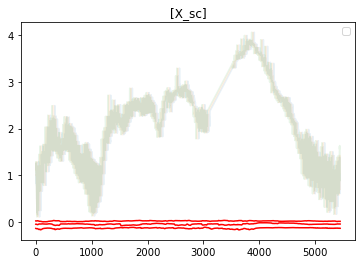

In [36]:
trainPred = build_lstm4().predict(Xtrain)
testPred = build_lstm4().predict(Xtest)

showresult([trainPred,testPred],Y)

In [55]:
def ab_lstm():
    global n_past,n_future,n_features
    inputA3 = keras.Input(shape=(n_past, n_features), name="cA3")
    inputD3 = keras.Input(shape=(n_past, n_features), name="cD3")
    inputD2 = keras.Input(shape=(n_past, n_features), name="cD2")
    inputD1 = keras.Input(shape=(n_past, n_features), name="cD1")
    #x is the CNN for approximate
    a = layers.CuDNNLSTM(200,return_sequences=False)(inputA3)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100,activation = 'relu')(a)
    a = layers.Dropout(0.2)(a)
    a = layers.Dense(100, activation='relu')(a)

    #y is the LSTM for detail  
    b = layers.LSTM(200,activation = 'sigmoid',return_sequences=False)(inputD3)
    b = layers.Dense(50,activation='sigmoid')(b)
    
    c = layers.LSTM(200,activation = 'sigmoid',return_sequences=False)(inputD2)
    c = layers.Dense(50,activation='sigmoid')(c)
    
    d = layers.LSTM(200,activation = 'sigmoid',return_sequences=False)(inputD1)
    d = layers.Dense(10,activation='sigmoid')(d)
    #combining 2 lstm
    com = layers.concatenate([a,b,c,d])
    # z = LSTM(200, activation='relu', return_sequences=False)(com)
    z = layers.Dense(100, activation="sigmoid")(com)
    # z = layers.CuDNNLSTM(200,return_sequences=False)(z)
    z = layers.Dense(n_future)(z)
    model = keras.Model(inputs=[inputA3, inputD3,inputD2,inputD1], outputs=z)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model

In [56]:
Xtrain = (Xa3[0],Xd3[0],Xd2[0],Xd1[0])
Xtest = (Xa3[1],Xd3[1],Xd2[1],Xd1[1])
model=ab_lstm()

history = model.fit(Xtrain,Y[0],epochs=epochs,validation_data=(Xtest,Y[1]),batch_size=batch,verbose=verbose,callbacks=callbacks)
trainPred = model.predict(Xtrain)
testPred = model.predict(Xtest)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cA3 (InputLayer)                [(None, 168, 10)]    0                                            
__________________________________________________________________________________________________
cu_dnnlstm_57 (CuDNNLSTM)       (None, 200)          169600      cA3[0][0]                        
__________________________________________________________________________________________________
dropout_60 (Dropout)            (None, 200)          0           cu_dnnlstm_57[0][0]              
__________________________________________________________________________________________________
dense_108 (Dense)               (None, 100)          20100       dropout_60[0][0]                 
___________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
showresult([trainPred,testPred],Y)